In [1]:
#!pip install yfinance

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load the stock data
# You can use any source or replace this with your own data
# In this example, I'm using Yahoo Finance to get historical stock data
# Make sure to install yfinance: pip install yfinance
import yfinance as yf

# Define the stock symbol and time period
symbol = "INFY"
start_date = "2018-01-31"
end_date = "2024-02-04"

# Download historical stock data
data = yf.download(symbol, start=start_date, end=end_date)

# Extract the closing prices
df = pd.DataFrame(data['Close'])


C:\Users\shiva\anaconda3\Lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed


In [3]:
df.head(10)

,Close
Date,
2018-01-31,9.005
2018-02-01,8.965
2018-02-02,8.875
2018-02-05,8.685
2018-02-06,8.735
2018-02-07,8.740
2018-02-08,8.555
2018-02-09,8.680
2018-02-12,8.810


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1512 entries, 2018-01-31 to 2024-02-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1512 non-null   float64
dtypes: float64(1)
memory usage: 23.6 KB


In [5]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 10

# Create sequences and labels
X, y = create_sequences(df_scaled, sequence_length)


In [6]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data for LSTM input (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [7]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

Epoch 1/50
38/38 [==============================] - 14s 22ms/step - loss: 0.0307
Epoch 2/50
38/38 [==============================] - 1s 22ms/step - loss: 0.0013
Epoch 3/50
38/38 [==============================] - 1s 21ms/step - loss: 9.5163e-04
Epoch 4/50
38/38 [==============================] - 1s 20ms/step - loss: 9.5544e-04
Epoch 5/50
38/38 [==============================] - 1s 20ms/step - loss: 9.4651e-04
Epoch 6/50
38/38 [==============================] - 1s 21ms/step - loss: 9.0857e-04
Epoch 7/50
38/38 [==============================] - 1s 22ms/step - loss: 9.0007e-04
Epoch 8/50
38/38 [==============================] - 1s 20ms/step - loss: 8.9983e-04
Epoch 9/50
38/38 [==============================] - 1s 22ms/step - loss: 9.0198e-04
Epoch 10/50
38/38 [==============================] - 1s 20ms/step - loss: 8.8644e-04
Epoch 11/50
38/38 [==============================] - 1s 21ms/step - loss: 8.7922e-04
Epoch 12/50
38/38 [==============================] - 1s 20ms/step - loss: 8.6402e

In [8]:
len(predictions)

301

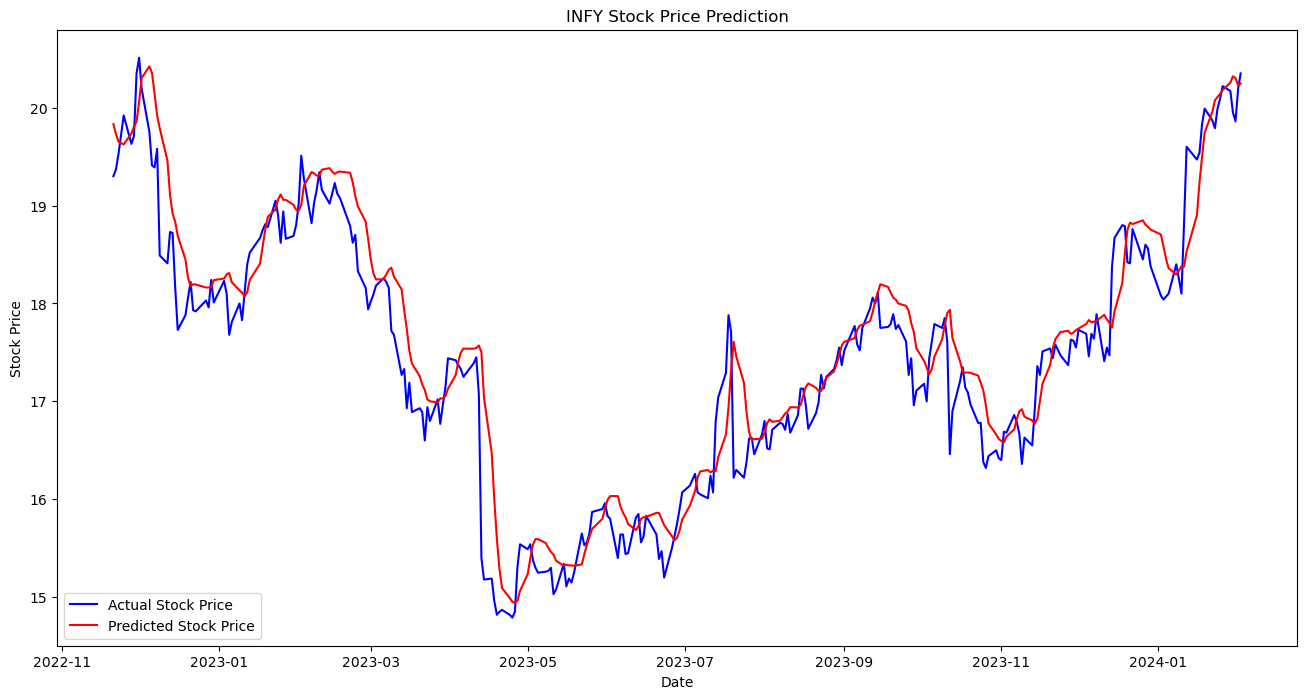

In [9]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.title(f'{symbol} Stock Price Prediction')
plt.plot(df.index[train_size + sequence_length:], df['Close'][train_size + sequence_length:], label='Actual Stock Price', color='blue')
plt.plot(df.index[train_size + sequence_length:], predictions, label='Predicted Stock Price', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [10]:
import pickle 
pickle_out = open("INFY_LSTM.pkl", mode = "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()

In [11]:
# Forecasting for the next 30 days
last_sequence = df_scaled[-sequence_length:]
forecast = []
for _ in range(20):
    input_sequence = last_sequence.reshape(1, sequence_length, 1)
    predicted_price = model.predict(input_sequence)
    forecast.append(predicted_price[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = predicted_price[0, 0]

# Inverse transform the forecasted prices
forecast = np.array(forecast).reshape(-1, 1)
forecast_actual = scaler.inverse_transform(forecast)


1/1 [==============================] - 0s 52ms/step


In [12]:
y_test_actual = scaler.inverse_transform(y_test)
len(y_test_actual)

301

In [13]:
# Print or use the forecasted prices for the next 30 days
print(forecast_actual)

[[20.328611]
 [20.406631]
 [20.48476 ]
 [20.567636]
 [20.652868]
 [20.741081]
 [20.828451]
 [20.910847]
 [20.989998]
 [21.074043]
 [21.159481]
 [21.242702]
 [21.32572 ]
 [21.408405]
 [21.490772]
 [21.572803]
 [21.654533]
 [21.73592 ]
 [21.816843]
 [21.897202]]


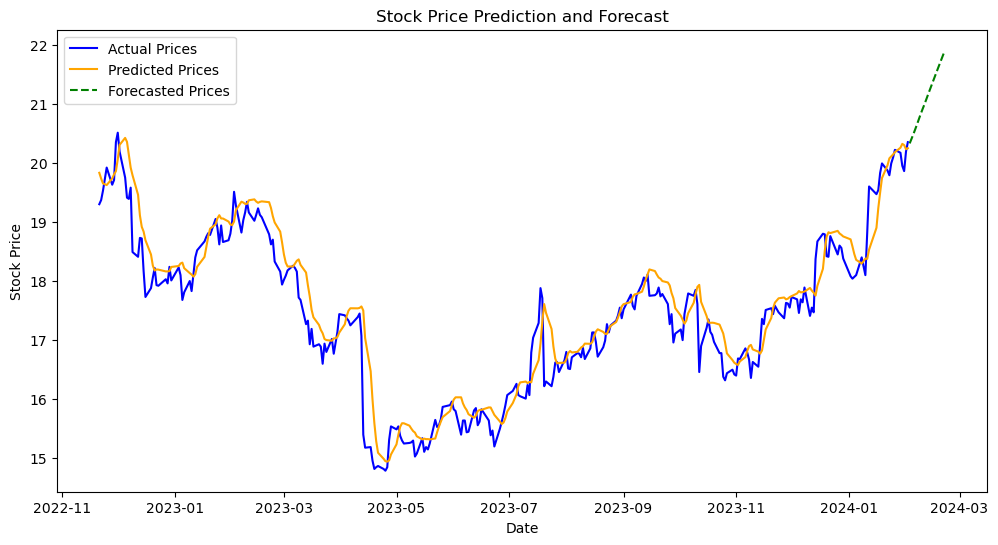

In [14]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], df['Close'][train_size + sequence_length:], label='Actual Prices', color='blue')
plt.plot(df.index[-len(predictions):], predictions, label='Predicted Prices', color='orange')
plt.plot(pd.date_range(df.index[-1], periods=21)[1:], forecast_actual, label='Forecasted Prices', linestyle='dashed', color='green')
plt.title('Stock Price Prediction and Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [15]:
pred = pd.DataFrame()
pred["predictions"] = pd.DataFrame(predictions)
pred["y_test_actual"] = pd.DataFrame(y_test_actual)
pred

,predictions,y_test_actual
0,19.831203,19.299999
1,19.732813,19.370001
2,19.651329,19.530001
3,19.624022,19.920000
4,19.735693,19.629999
...,...,...
296,20.255846,20.170000
297,20.321335,19.950001
298,20.300795,19.860001
299,20.231281,20.190001


In [16]:
# Compute RMSE and MAPE

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100

# Print or use the forecasted prices for the next 30 days
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)

Root Mean Squared Error (RMSE): 0.4227467812998339
Mean Absolute Percentage Error (MAPE): 1.7888443718467133
